<a href="https://colab.research.google.com/github/Dharren09/Deep_Residual_Learning_on_Brain_Tumors/blob/main/residual_learning_from_scratch_on_BrainTumor_classification_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders # splitting folders
# !pip install torch-xla  # module enables pytorch tensors to work with TPUs
!pip install torch-summary

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import draw_bounding_boxes
import splitfolders
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
from typing import Optional, Callable
from torch import optim

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Check if TPU is available
# if 'COLAB_TPU_ADDR' in os.environ:
#   try:
#     import torch_xla.core.xla_model as xm
#     device = xm.xla_device()
#     print('Using TPU')
#   except ImportError:
#     # If torch_xla is not available, fall back to checking GPU and CPU
#     if torch.cuda.is_available():
#       device = torch.device('cuda')
#       print('Using GPU')
#     else:
#       device = torch.device('cpu')
#       print('Using CPU')

# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Using GPU')
# Fallback to CPU
else:
  device = torch.device('cpu')
  print('Using CPU')

Using GPU


In [ ]:
# ======================================================
# file opening and EDA
# ======================================================

In [ ]:
# download dataset from kaggle
!kaggle datasets download -d makohadharrenpius/brain-tumor-xrays-dataset

Dataset URL: https://www.kaggle.com/datasets/makohadharrenpius/brain-tumor-xrays-dataset
License(s): Apache 2.0
100% 107M/107M [00:04<00:00, 34.9MB/s]
100% 107M/107M [00:04<00:00, 25.2MB/s]


In [ ]:
#unzip

import subprocess

subprocess.run(["unzip", "/content/brain-tumor-xrays-dataset.zip", "-d", "/content/data"])

CompletedProcess(args=['unzip', '/content/brain-tumor-xrays-dataset.zip', '-d', '/content/data'], returncode=0)

In [ ]:
data_dir = "/content/data/Brain_Tumor_Dataset"
files = os.listdir(data_dir)
print(files)

['metadata_rgb_only.csv', 'metadata.csv', 'case_dataset']


In [ ]:
case_studies_dir = [os.path.join(data_dir, cs) for cs in os.listdir(data_dir) if cs == 'case_dataset']

for path in case_studies_dir:
    case_studies = os.listdir(path)
    print(case_studies)

['Healthy', 'Brain_Tumor']


In [ ]:
# ========================================
# Reading the image metadata
# ========================================

metadata = pd.read_csv('/content/data/Brain_Tumor_Dataset/metadata.csv')
metadata.drop(columns='Unnamed: 0', axis=-1, inplace=True)
print(metadata.head(10).to_markdown())

|    | image             | class   | format   | mode   | shape         |
|---:|:------------------|:--------|:---------|:-------|:--------------|
|  0 | Cancer (1).jpg    | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 | Cancer (1).png    | tumor   | PNG      | L      | (300, 240)    |
|  2 | Cancer (1).tif    | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 | Cancer (10).jpg   | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 | Cancer (10).tif   | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  5 | Cancer (100).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  6 | Cancer (1000).jpg | tumor   | JPEG     | RGB    | (290, 250, 3) |
|  7 | Cancer (1001).jpg | tumor   | JPEG     | RGB    | (620, 620, 3) |
|  8 | Cancer (1002).JPG | tumor   | JPEG     | RGB    | (338, 264, 3) |
|  9 | Cancer (1003).jpg | tumor   | JPEG     | RGB    | (442, 353, 3) |


In [ ]:
print(metadata['format'].value_counts()) # How many images per image format

format
JPEG    4496
TIFF      86
PNG       18
Name: count, dtype: int64


In [ ]:
print(metadata['mode'].value_counts()) # How many images per image mode (RGB/L/P/RGBA)

mode
RGB     4461
L        132
RGBA       5
P          2
Name: count, dtype: int64


In [ ]:
# How many images per case set

class_dict = {}

for case_folder in case_studies:
  class_path = os.path.join(case_studies_dir[0], case_folder)
  images = 0
  for image in os.listdir(class_path):
    images += 1
  class_dict[case_folder] = images

print(f"Total images: {sum(class_dict.values())}")
print("Image per class:")
for cls_, count in class_dict.items():
  print(f"\t{cls_}: {count}")

Total images: 4600
Image per class:
	Healthy: 2086
	Brain_Tumor: 2514


In [ ]:
# ===========================================================================
# Calculating for ratio to identify any imbalances between the cases studies
# ===========================================================================

def calculate_ratio(x):
  counts = torch.tensor(list(x.values()))
  return torch.max(counts) / torch.min(counts)

Ratio = calculate_ratio(class_dict)
print(f"Imbalance ratio: {Ratio}")

Imbalance ratio: 1.2051774263381958


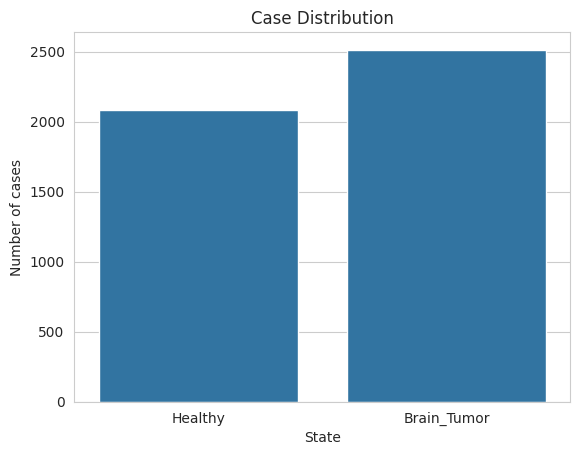

In [ ]:
# =========================================
# Case distribution
# =========================================

sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()))
plt.title('Case Distribution')
plt.xlabel('State')
plt.ylabel('Number of cases')
plt.show()

In [ ]:
# ============================================================
# Visualizations of some images given the directory path
# ============================================================

def visualize_images(dir_path, n_images=3, n_columns=3, image_size=(224, 224)):
  image_paths = []

  if not os.path.isdir(dir_path):
    raise (f"The directory path is invalid or doesnot lead to a directory: {dir_path}")

  for case_folder in case_studies:
    class_path = os.path.join(case_studies_dir[0], case_folder)
    if not os.path.isdir(class_path):
      continue
    image_path = [os.path.join(class_path, im) for im in os.listdir(class_path)][:n_images // len(case_studies)]
    image_paths.extend(image_path)

  # visualization logic
  rows = (len(image_paths) + n_columns - 1) // n_columns
  fig, axes = plt.subplots(rows, n_columns, figsize=(15, 5*rows)) # 15inches wide and 5inches tall per row

  # some image preprocessing
  for _, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert('RGB') # one single color mode for uniformity
    image.resize(image_size)
    row = _ // n_columns
    col = _ % n_columns

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"State: {case_studies[_ // (n_images // len(case_studies))]}")
    axes[row, col].axis('off')

  for j in range(len(image_paths), rows * n_columns):
    fig.delaxes(axes[j // n_columns, j % n_columns])

  plt.tight_layout()
  plt.show()

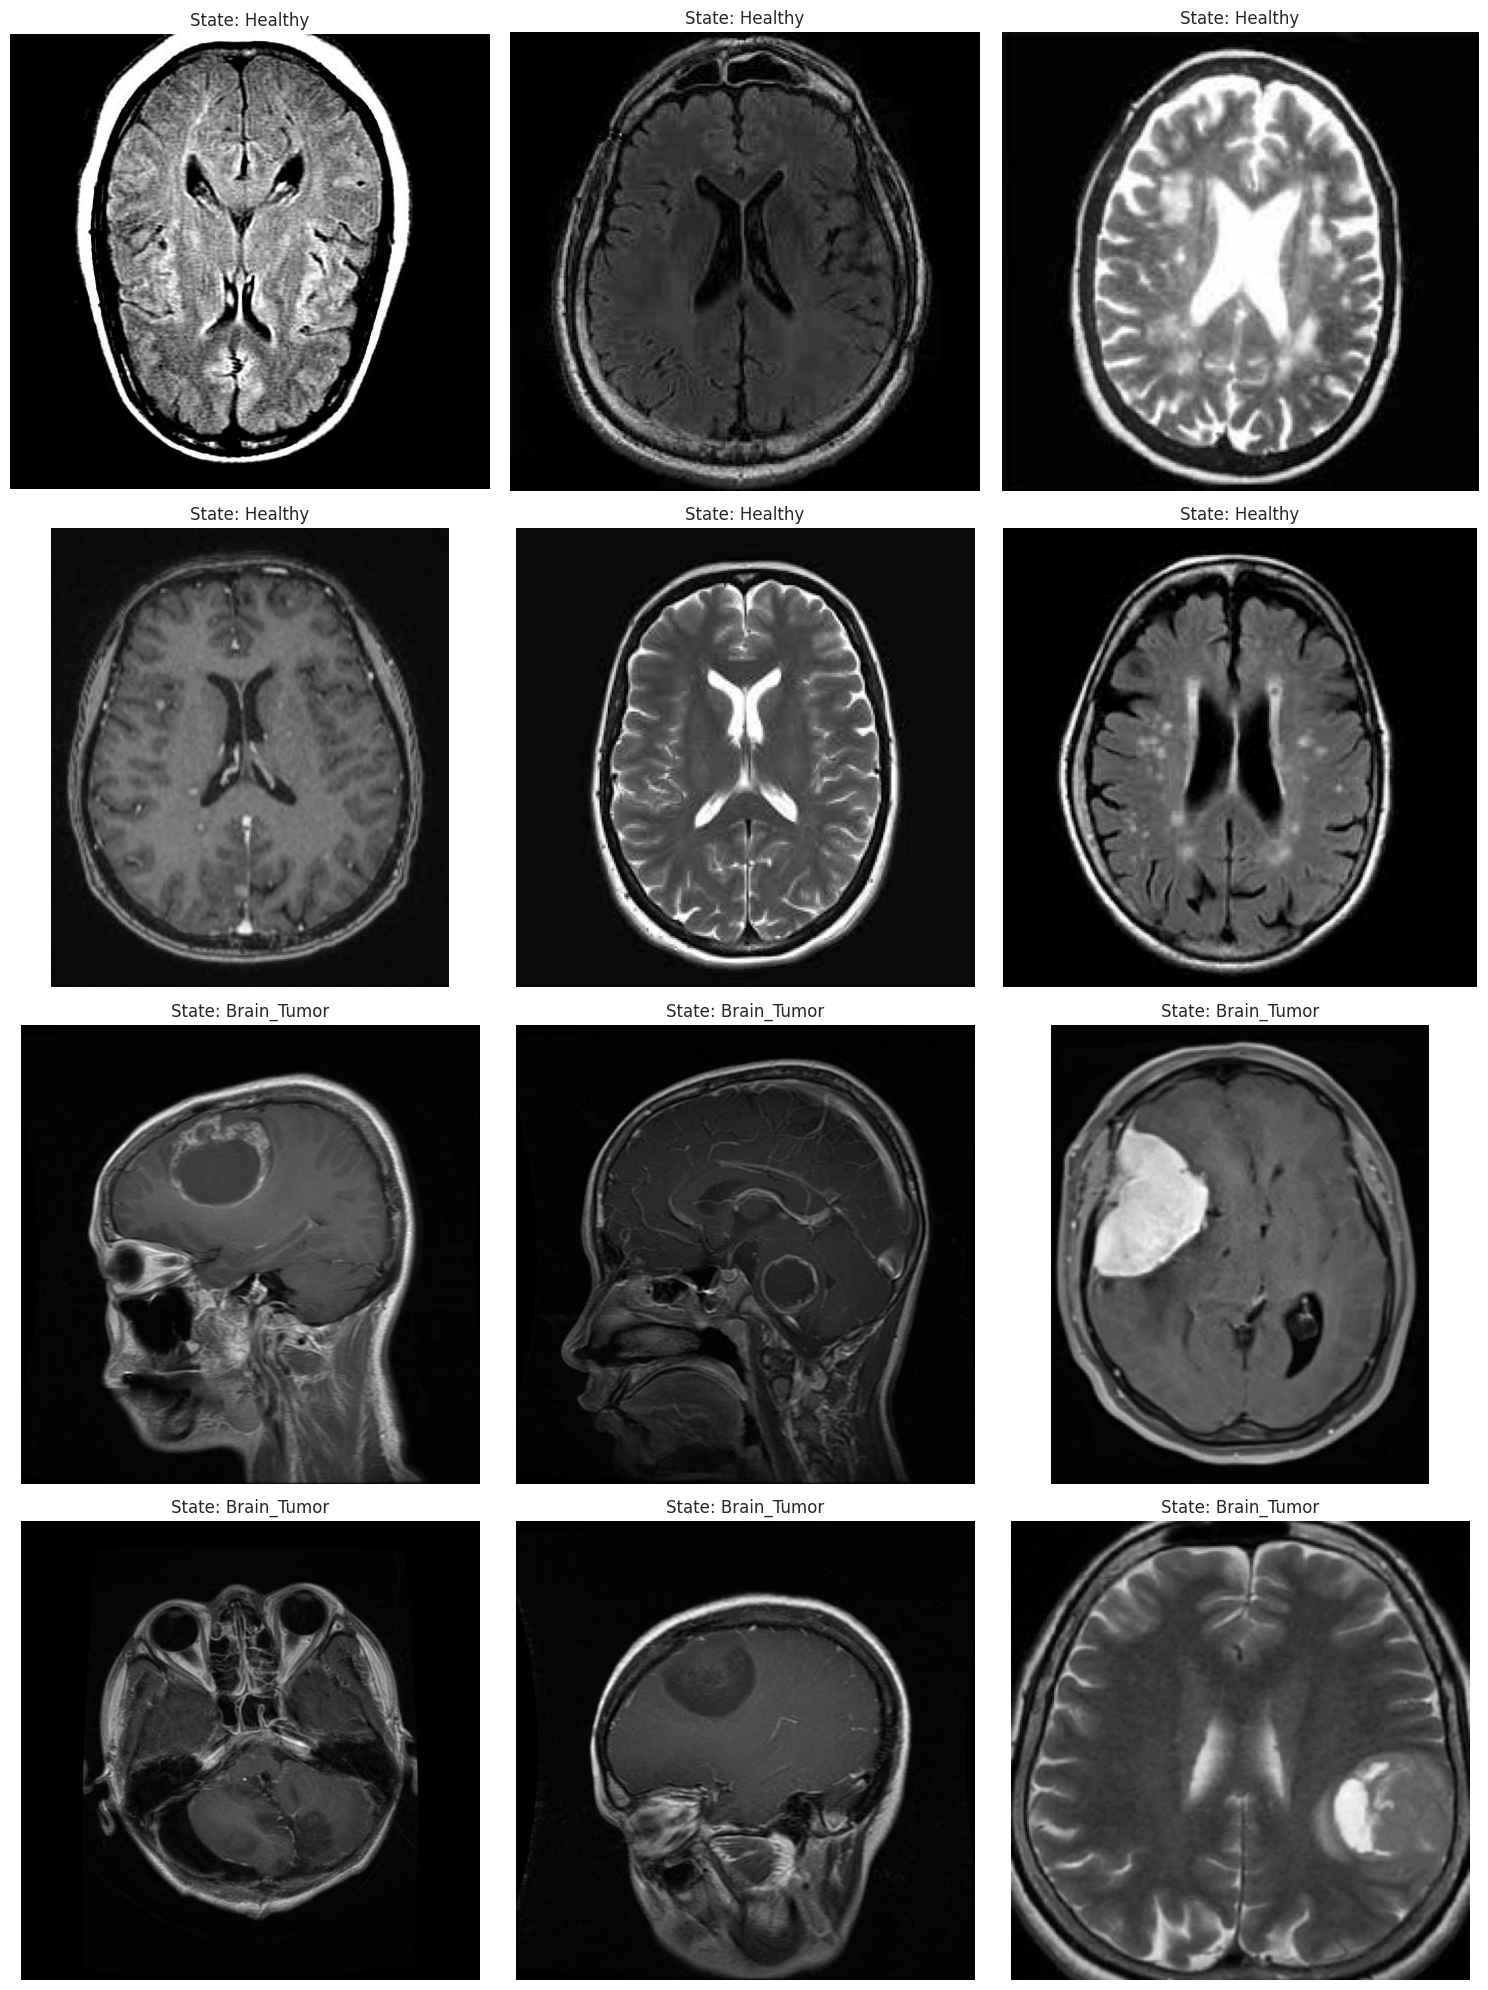

In [ ]:
# Visualize 12 images from the case directory

for case_path in case_studies_dir:
  visualize_images(case_path, n_images=12)

In [ ]:
# ========================================
# Creating a total images-paths list from
# all the case study folders combined
# ========================================

classes = os.listdir(case_studies_dir[0])

image_paths_list = []

for case_folder in classes:
  case_path = os.path.join(case_studies_dir[0], case_folder)
  image_path = [os.path.join(case_path, im) for im in os.listdir(case_path)]
  image_paths_list.extend(image_path)
print(len(image_paths_list))

4600


In [ ]:
# ============================================
# data splitting into train and test
# ============================================

def train_test_splitter(
    data_path,
    train_size=0.5,
    test_size=0.25,
    val_size=None,
    random_state=42,
    output='workingDataset'
):
  """Function that splits the images_paths into ratios of train, test and val
  given the directory path.

  Built on top of splitfolders.ratio()

  Returns:
      folder containing train_dir, test_dir, val_dir
  """
  if not os.path.isdir(data_path):
    raise ValueError(f"Invalid directory provided: {data_path}")

  if val_size is not None:
      if (train_size + test_size + val_size) != 1:
          raise ValueError("The sum of train_size, test_size, and val_size must equal 1.")
      ratio = (train_size, val_size, test_size)
  else:
      if ((train_size + (1 - (train_size + test_size))) + test_size) != 1:
          raise ValueError("The sum of train_size and test_size must equal 1.")
      ratio = (train_size, test_size)

  splitfolders.ratio(data_path, ratio=ratio, seed=random_state, output=output)

  data_dir = '/content/{output}'
  data_dir = pathlib.Path(data_dir)

  train_dir = data_dir / 'train'
  test_dir = data_dir / 'test'
  if val_size: val_dir = data_dir / 'val'
  else: None

  return {
      'train_directory': train_dir,
      'test_directory': test_dir,
      'val_directory': val_dir
  }


train_dir, val_dir, test_dir = train_test_splitter(case_studies_dir[0], val_size=0.25)

Copying files: 4600 files [00:01, 2653.43 files/s]


In [ ]:
# ======================================
# mmber of samples per set
# ======================================

count_dict = {}
workingfile_path = '/content/workingDataset'
dirs = os.listdir(workingfile_path)

# loop through (train, test, val folders)
for dir_ in dirs:
  sub_dir_path = os.path.join(workingfile_path, dir_) # e.g '/content/workingDataset/train'
  subdir_dict = {} # dict to store contents of the subdirectories; (Healthy, Brain_tumor)

  # iterate through the subdirectories
  for folder in os.listdir(sub_dir_path):
    image_count = 0
    # for every image/file within the subdirectory
    for filename in os.listdir(os.path.join(sub_dir_path, folder)):
      # Does the filename exist in the subdir_dict dictionary
      if filename in subdir_dict.values():
        image_count = 1 # store first element
      image_count += 1 # increment the existing element by count one

    # store count to the subdir_dict
    subdir_dict[folder] = image_count

  # Add the subdir-dict to the main dictionary
  count_dict[dir_] = subdir_dict

count_dict

{'test': {'Healthy': 522, 'Brain_Tumor': 629},
 'val': {'Healthy': 521, 'Brain_Tumor': 628},
 'train': {'Healthy': 1043, 'Brain_Tumor': 1257}}

In [ ]:
# ==============================================================
# Calculating normalization parameters: using only the train set
# Why? we donot want to expose our model to our testing and
# validation sets that this would interfere with our models
# performance and accuracy.
# ==============================================================

# TODO: Find out if truncating the mean actually provides better and resilient
#       normalization metrics for our model

def calculate_normalization_parameters(dataset):
  for images, _ in dataset:
    # image shape: torch.Size([64, 3, 224, 224])
    images = images.to(device)

    means = images.mean(dim=[0,2,3])
    stds = images.std(dim=[0,2,3])

  return means, stds

In [ ]:
# creating a train dataset without transformations
# to be used to calculate the normalization params

train_path = '/content/workingDataset/train'

norm_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # convert all images to RGB
    transforms.ToTensor(), # create a tensor object
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224))
])

train_norm_set = ImageFolder(train_path, transform=norm_transform)
train_norm_loader = DataLoader(train_norm_set, batch_size=64, shuffle=False, pin_memory=False, num_workers=4)


means, stds = calculate_normalization_parameters(train_norm_loader)

print(f"means: {means}")
print(f"stds: {stds}")

means: tensor([0.2084, 0.2084, 0.2084], device='cuda:0')
stds: tensor([0.2258, 0.2259, 0.2259], device='cuda:0')


In [ ]:
# =============================================
# Loading data
# =============================================

train_root = '/content/workingDataset/train'
test_root = '/content/workingDataset/test'
val_root = '/content/workingDataset/train'

means, stds = [0.2084, 0.2084, 0.2084], [0.2258, 0.2259, 0.2259]

train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224,224)),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.RandomRotation(degrees=(0,360)),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.PILToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ConvertImageDtype(torch.float64),
    transforms.Normalize(mean=means, std=stds)
])

# the test and val sets are not augmented bse they are supposed to mimic
# real-world scenarios.
test_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224,224)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float64),
    transforms.Normalize(mean=means, std=stds)
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize((224,224)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float64),
    transforms.Normalize(mean=means, std=stds),
])

train_dataset = ImageFolder(root=train_root, transform=train_transform)
test_dataset = ImageFolder(root=test_root, transform=test_transform)
val_dataset = ImageFolder(root=val_root, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True if device=="cuda" else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True if device=="cuda" else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True if device=="cuda" else False
)

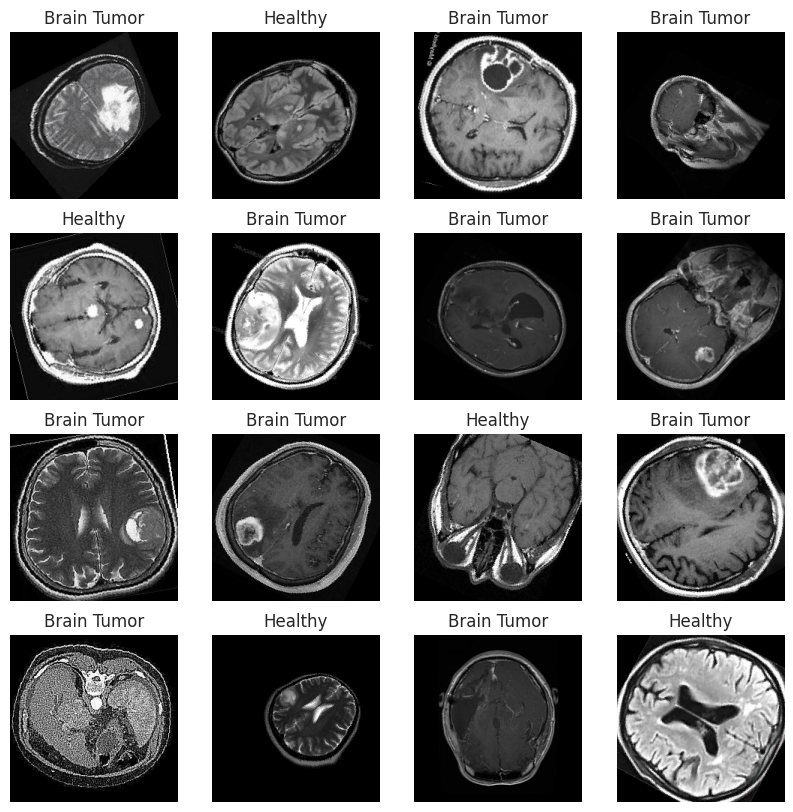

In [ ]:
# ============================================
# visualizing some transformed images from
# the train dataset object
# ============================================

# TODO: visualizing using the DataLoader object

label_dict = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}

fig, axes = plt.subplots(nrows=4, ncols=4, sharex=False,
                         sharey=False, figsize=(10,10))

for i, ax in enumerate(axes.flat):
  sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
  image, label = train_dataset[sample_idx]
  image = image.permute((1, 2, 0)).numpy()  # Convert to HWC format
  # De-normalize the image
  image = image * np.array(stds) + np.array(means)
  image = np.clip(image * 255.0, 0, 255).astype('uint8')  # Scale to 0-255 and convert to uint8
  ax.imshow(image)
  ax.set_title(label_dict[label])
  ax.axis('off')

plt.show()

In [ ]:
# Shapes of the sets

data_loaders = {'Training data': train_loader, 'Testing data': test_loader, 'Validation data': val_loader}

for key, value in data_loaders.items():
    images, labels = next(iter(value))
    print(f"{key}")
    print(f"Shape of X: {images.shape}")
    print(f"Shape of y: {labels.shape}, dtype of y: {labels.dtype}\n")

Training data
Shape of X: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]), dtype of y: torch.int64

Testing data
Shape of X: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]), dtype of y: torch.int64

Validation data
Shape of X: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]), dtype of y: torch.int64



In [ ]:
# ================================================================
# Model Creation
# ================================================================

In [ ]:
# =================================
# utils
# =================================

# normalization layers
def get_norm_layer(norm_layer: str, num_features: int):
  if norm_layer == 'batch':
    return nn.BatchNorm2d(num_features, momentum=0.1)
  elif norm_layer == 'layer':
    return nn.LayerNorm(num_features)
  elif norm_layer == 'group':
    return nn.GroupNorm(num_groups=32, num_channels=num_features)
  elif norm_layer == 'instance':
    return nn.InstanceNorm2d(num_features)
  else:
    raise ValueError(f"Unknown normalization type: {norm_layer}")

def _initialize_weights(module):
  """
  Initialize weights for the layers in the Residual Block.

  Normalized weight initialization scheme was used to help address the vanishing/exploding gradients problem.
  As neural networks get deeper, they become susceptible to these issues, where gradients can either become
  too small (vanish) or too large (explode). This can hinder the learning process, causing the model to either
  converge very slowly or not at all.

  Specifically, we use Kaiming (He) initialization for convolutional layers, which is designed to maintain
  the variance of activations and gradients throughout the network. This helps in training deeper networks
  more effectively by ensuring that the scale of the input remains consistent across layers. For batch
  normalization layers, we initialize the weights to 1 and the biases to 0, which helps in maintaining the
  identity transform at the beginning of training.
  """
  for module in module.modules():
    if isinstance(module, nn.Conv2d):
      nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
  else:
    if isinstance(module, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm, nn.InstanceNorm2d)):
      nn.init.constant_(module.weight, 1) # same as nn.init.ones_()
      nn.init.constant_(module.bias, 0) # same as nn.init.zeros_()
    elif isinstance(module, nn.Linear):
      nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
      nn.init.constant_(module.bias, 0)

In [ ]:
# ============================
# Residual Block
# ============================

class ResidualBlock(nn.Module):
  """
  Implementation of the residual block as described in the paper:
  "Deep Residual Learning for Image Recognition" by Kaiming He et al. [1]

  The residual block consists of 2 or 3 convolutional layers with batch normalization and ReLU activations.
  It also includes shortcut connections to add the input to the output of the convolutional layers,
  implementing the residual learning.

  The main idea is to learn residual functions with reference to the layer inputs, instead of learning unreferenced
  functions directly.
  This helps mitigate the vanishing/exploding gradients problem, allowing the training of very deep networks.

  Args:
      in_channels (int): The number of input channels.
      out_channels (int): The number of output channels.
      num_convs (int): The number of convolutional layers in the block.
      subsample (bool): Whether to use strided convolution for downsampling.
      padding (int): The padding for the convolutional layers.
      norm_layer (str): The normalization techinique to use
      initialize_weights (bool): wether to initilize the weights or not

  References:
  [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition".
      Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778.
  """
  def __init__(
      self,
      in_channels: int,
      out_channels: int,
      num_convs: int = 2,
      subsample: bool = True,
      padding: int = 1,
      norm_layer: str = 'batch',
      initialize_weights: bool = False
  ):
    super(ResidualBlock, self).__init__()
    # self.in_channels = in_channels
    # self.out_channels = out_channels
    # self.num_convs = num_convs
    # self.subsample = subsample
    # self.padding = padding

    # if subsample is True, use stride of 2 for the first conv leg to downsample
    strides = 2 if subsample else 1

    # List to hold the convolutional and batch normalization layers
    self.convs = nn.ModuleList()
    self.bns = nn.ModuleList()

    for i in range(num_convs):
      # setting the in_channels and strides in the first layer
      # and out_channels for the subsequent convolution layers
      if i == 0:
        self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=padding, bias=False))
      else:
        self.convs.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=padding, bias=False))
      self.bns.append(get_norm_layer(norm_layer, out_channels))

    self.activation = nn.ReLU(inplace=True)

    # Downsample the input if the number of channels or feature map size changes
    self.downsample = nn.Sequential(
        nn.AvgPool2d(kernel_size=1, stride=1, padding=0),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides, bias=False),
        get_norm_layer(norm_layer, out_channels)
    ) if subsample or in_channels != out_channels else None

    if initialize_weights:
      self.apply(_initialize_weights)

  def forward(self, x):
    """
    Forward pass for the Residual Block.

    Args:
        x (Tensor): Input tensor with shape (batch_size, channels, height, width).

    Returns:
        y (Tensor): Output tensor after applying the residual block.
    """
    identity = x # reserving the original inputs; useful for identity mapping
    print(f"shape of input: {identity.shape}")
    y = x

    for conv, bn in zip(self.convs, self.bns):
      y = self.relu(bn(conv(x)))
    print(f"shape of y before downsampling: {y.shape}")

    if self.downsample:
      identity = self.downsample(identity)
      print(f"shape of the identity matrix after downsampling (residualblocks): {identity.shape}")

    # Add the identity (original input) to the output of the convolutional layers
    # This is the core concept of residual learning
    y += identity
    y = self.relu(y)

    return y

In [ ]:
# TODO: i)   implementing a bottleneck architecture
#       ii)  trying out various normalizations on the residual layers
#       iii) identifying the role of expansions on model performance
#       iv)  optimizing the model basing on calculations made on the input channels
#       v)   How to optimize strides to ensure even better performance of ResNets
#       vi)  optimizimg a model that can even learn with excellence on a limited dataset
#       vii) Hyper-parameter tunning

class BottleneckResidualBlocks(nn.Module):
  def __init__(self,
               in_channels: int,
               out_channels: int,
               subsample=False,
               padding=1,
               groups=1,
               dilation=1,
               expansions: int = 4,
               norm_layer: str = 'batch',
               initialize_weights=False,
  ):
    super(BottleneckResidualBlocks, self).__init__()
    # self.in_channels = in_channels
    # self.out_channels = out_channels
    # self.padding = padding
    # self.groups = groups
    # self.dilation = dilation
    # self.expansions = expansions
    # self.norm_layer = norm_layer

    strides = 2 if subsample else 1

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
    self.bn1 = get_norm_layer(norm_layer, out_channels)
    self.activation1 = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=strides, padding=padding,
                           dilation=dilation, groups=groups)
    self.bn2 = get_norm_layer(norm_layer, out_channels)
    self.activation2 = nn.ReLU(inplace=True)

    self.conv3 = nn.Conv2d(out_channels, out_channels * expansions, kernel_size=1, bias=False)
    self.bn3 = get_norm_layer(norm_layer, out_channels * expansions)
    # self.activation3 = nn.ReLU(inplace=True)

    self.downsample = nn.Sequential(
        # nn.AvgPool2d(kernel_size=1, stride=1, padding=0),
        nn.Conv2d(in_channels, out_channels * expansions, kernel_size=1, stride=strides, bias=False),
        get_norm_layer(norm_layer, out_channels * expansions)
    ) if subsample or in_channels != out_channels else None

    # initializing weight: as much as this can be computationally expensive, the overall benefits make
    # our model improve on it's robustness.
    if initialize_weights:
      self.apply(_initialize_weights)

  def forward(self, x):
    identity = x

    out = self.activation1(self.conv1(self.bn1(x)))
    out = self.activation2(self.conv2(self.bn2(out)))
    out = self.conv3(self.bn3(out))
    print(f"shape of output before downsampling: {out.shape}")

    if self.downsample:
      identity = self.downsample(identity)
      print(f"shape of the identity matrix after downsampling (Bottleneckresidual): {identity.shape}")

    out += identity
    out = nn.ReLU(inplace=True)(out)

    return out

In [ ]:
# ======================================
# ResNets
# ======================================


class ScanResnet(nn.Module):
  """
  Implementation of the deep residual learning network as described in the paper:
  "Deep Residual Learning for Image Recognition" by Kaiming He et al. [1]

  implements a Bottleneck architecture if layers exceed 30

  The key aspects of this ResNet implementation are:
  - The network consists of an initial convolutional layer, followed by several stages of residual blocks.
  - Each residual block contains two or three convolutional layers with batch normalization and ReLU activations.
  - Shortcut connections are used to add the input of the residual block to the output of the convolutional layers, implementing the residual learning.
  - Downsampling is performed using strided convolution in the residual blocks when the spatial dimensions need to be reduced.
  - The final output is obtained through global average pooling and a fully connected layer.

  Args:
      layers (tuple(int,int,int,int)): Tuple containing the number of residual blocks in each stage of the network.
      n_classes (int): The number of output classes.

  References:
  [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition".
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778.
  """
  def __init__(
      self,
      layer_config: tuple  = [],
      n_classes: int = 2,
      expansions: int = 4
  ):

    super(ScanResnet, self).__init__()
    self.expansions = expansions
    self.layer_config = layer_config
    self.in_channels = 64

    block_layers = 3 # number of layers per block
    total_layers = sum(layer_config) * block_layers + 2      # 2 -> initial convolutional layer + fully connected layer(fc)
    print(f"ScanResnet-{total_layers}\n\n")

    block_type = ResidualBlock if total_layers <= 30 else BottleneckResidualBlocks # setting block layer

    # Initial convolution layer
    self.convInitial = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bnInitial = nn.BatchNorm2d(64)
    self.activation = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.conv1 = self.create_layers(block_type, 64, layer_config[0], subsample=False) # layer 1
    self.conv2 = self.create_layers(block_type, 128, layer_config[1], subsample=True) # layer 2
    self.conv3 = self.create_layers(block_type, 256, layer_config[2], subsample=True) # layer 3
    self.conv4 = self.create_layers(block_type, 512, layer_config[3], subsample=True) # layer 4

    # reducing the feature map to single value (1,1), allowing the net to handle images of different sizes
    self.avgPool = nn.AdaptiveAvgPool2d((1,1))
    self.fcOut = nn.Linear(512 * (self.expansions if isinstance(block_type, BottleneckResidualBlocks) else 1), n_classes) # the input should match the number of filters in the last convolutional layer
    self.softmax = nn.Softmax(dim=-1)

    # Initializing weights in the fully connected output layer
    self.apply(_initialize_weights)

  # create layers
  def create_layers(self, block, out_channels, blocks, subsample):
    layers = []
    layers.append(block(self.in_channels, out_channels, subsample))
    self.in_channels = out_channels * (self.expansions if isinstance(block, BottleneckResidualBlocks) else 1)
    for _ in range(1, blocks):
      layers.append(block(self.in_channels, out_channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    # reduce the spatial dimensions and increase the number of color dimensions
    y = self.activation(self.bnInitial(self.convInitial(x)))
    y = self.maxpool(y) # decreasing the spatial dimensions further while aggregating the features

    y = self.conv1(y) # layer 1
    y = self.conv2(y) # layer 2
    y = self.conv3(y) # layer 3
    y = self.conv4(y) # layer 4

    y = self.avgPool(y)
    y = torch.flatten(y, 1)
    y = self.fcOut(y) # fully connected to map pooled features to the number of classes
    y = self.softmax(y) # getting the class probabilities

    return y

In [ ]:
# ================================================
# Evaluation
# ================================================

# TODO: evaluation interms of top-1% and top-5%

def evaluate(model, dataloader):
  """
  Evaluate the ResNet model on the given dataset.

  Args:
      model (nn.Module): The ResNet model to evaluate.
      dataloader (DataLoader): DataLoader for the dataset to evaluate on.

  Returns:
      float: The error percentage of the model on the dataset.
  """

  # require_grad=False because redundant gradients can be computationally expensive
  y_true = torch.tensor([], dtype=torch.int32).to(device=device)
  y_pred = torch.tensor([], dtype=torch.int32).to(device=device)

  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():  # Disable gradient calculation
    for images, labels in dataloader:
      images, labels = images.to(device).float(), labels.to(device)
      predictions = model(images)  # Get model predictions

      # Get class with the highest probability
      _, predicted = torch.max(predictions, 1)

      y_true = torch.cat([y_true, labels], dim=0)
      y_pred = torch.cat([y_pred, predicted], dim=0)

  # Calculate error as a percentage
  error = (y_pred != y_true).float().mean().item() * 100
  accuracy = (y_pred == y_true).sum().item() / y_true.size(0)

  # top-5 accuracy
  top5_pred = predictions.top5(5, dim=1)[1]
  top5_correct = top5_pred.eq(labels.view(-1,1).expand_as(top5_pred)) # checking if labels are in the top 5
  top5_accuracy = top5_correct.sum().item() / y_true.size(0) * 100 # Top 5 accuaracy percentage

  return error, accuracy, top5_accuracy, y_pred  # Return the error percentage as a float

In [ ]:
# ================================================
# Training
# ================================================

def train(model, n_epochs, train_loader, test_loader,
          criterion, optimizer, device, model_path=None,
          results_path=None, scheduler=None, log_frequency=30):

  model = model.to(device).float()

  # Initialize results DataFrame
  results_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_err', 'train_accuracy',
                                     'test_loss', 'test_err', 'test_accuracy'])

  best_test_err = float('inf')  # Initialize best test error to infinity

  for epoch in range(n_epochs):
    model.train()  # Switch to training mode
    running_loss = 0.0
    total_train_loss = 0.0

    for i, data in enumerate(train_loader):
      images, labels = data  # Accessing the images and labels
      images, labels = images.to(device).float(), labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(images)  # Model predictions
      loss = criterion(outputs, labels)  # Calculate loss
      loss.backward()  # Backpropagation
      optimizer.step()  # Update weights

      # Track running loss
      running_loss += loss.item()
      total_train_loss += loss.item()

      if (i + 1) % log_frequency == 0:  # Log every 'log_frequency' batches
        print(f"Epoch [{epoch + 1}/{n_epochs}], Batch [{i + 1}], Loss: {running_loss / log_frequency:.3f}")
        running_loss = 0.0

    # Step the learning rate scheduler
    if scheduler:
        scheduler.step()

    # Evaluation loop
    model.eval()
    with torch.no_grad():
      train_loss = total_train_loss / len(train_loader)  # Average train loss
      train_err, train_accuracy, _, _ = evaluate(model, train_loader, device)
      test_err, test_accuracy, _, _ = evaluate(model, test_loader, device)
      test_loss = total_train_loss / len(train_loader)  # Average test loss (you may want to calculate this differently)

    # Log results
    results_df = results_df.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_err': train_err,
        'train_accuracy': train_accuracy,
        'test_loss': test_loss,
        'test_err': test_err,
        'test_accuracy': test_accuracy
    }, ignore_index=True)

    if results_path is not None:
      results_df.to_csv(results_path, index=False)

    print(f'Epoch [{epoch + 1}/{n_epochs}], Train Error: {train_err:.4f}, Test Error: {test_err:.4f}')

    # Save the model if the test error improved
    if model_path is not None and test_err < best_test_err:
      torch.save(model.state_dict(), model_path)
      best_test_err = test_err  # Update best test error

    print("Finished Training")
    model.eval()
    return model, results_df  # Return the trained model and results DataFrame

In [ ]:
# # Qn: How many iterations happen in an epoch?
# iterations = 0
# for i, data in enumerate(train_loader, 0):
#     iterations +=1
# print(iterations)

In [ ]:
# ==================================================
# Calculating training params
# ==================================================

epochs = 100

# OPTIMISER PARAMETERS
lr = 0.001
momentum = 0.1
weight_decay = 0.0001

# LEARNING RATE ADJUSTMENT

# Milestone Ratio * Total Iterations per Epoch = Iterations per Milestone
# using at 10% of an epoch
# 0.1 * 42 iterations = 4.2 iterations (rounded down to 4)

# snapshot = [i for i in range(4, iterations + 1, 4)]

# Divide learning rate by 10 at each milestone
gamma = 0.1

# Exponential Decay: Gradually decrease the learning rate over time, e.g., lr = lr * gamma^epoch.
# Cosine Annealing: Decrease the learning rate in a cosine pattern, e.g., lr = 0.5 * (1 + cos(pi * epoch/epochs)) * lr.

# reduce lr after 30 epochs
patience = 30

In [ ]:
# ===================================
# Training our ResNets
# ===================================

# TODO: Figuring out how to define the different number of layers as structured in the ResNets.
# based on our 2 or 3 Residual blocks as we already know.
# [3,4,6,3]

# n_layers = [3,4,6,3] = 39


# total_layers = sum(n_layers)

# model_1 = ResNets([3,4,6,3], n_classes=2)
# print(model_1)



# criterion = nn.CrossEntropyLoss(label_smoothing=0.5)
# optimizer = optim.SGD(model_1.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=gamma, patience=patience)
# results_file = f'results/ScanNet{total_layers}.csv'
# model_file = f'pretrained/ScanNet{total_layers}.pt'
# train(model_1, n_epochs=epochs, train_loader=train_loader, test_loader=test_loader, criterion=criterion, optimizer=optimizer,
#       device=device, model_path=model_file, results_path=results_file, scheduler=scheduler)

In [ ]:
model_1 = ScanResnet([3,4,6,3], n_classes=2)
print(model_1)

ScanResnet-50


ScanResnet(
  (convInitial): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bnInitial): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): BottleneckResidualBlocks(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )


In [ ]:
model_2 = ScanResnet([2,2,2,2], n_classes=2)
print(model_2)

ScanResnet-26


ScanResnet(
  (convInitial): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bnInitial): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): ResidualBlock(
      (convs): ModuleList()
      (bns): ModuleList()
      (activation): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (convs): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0-1): 2 x BatchNorm2d(64, eps=1

In [ ]:
model_3 = ScanResnet([2,5,5,3], n_classes=2, expansions=2) # expansions squeezed to 2
print(model_3)

ScanResnet-47


ScanResnet(
  (convInitial): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bnInitial): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): BottleneckResidualBlocks(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )


In [ ]:
model_4 = ScanResnet([1,1,1,1], n_classes=2, expansions=4) # expansions squeezed to 2
print(model_4)

ScanResnet-14


ScanResnet(
  (convInitial): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bnInitial): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): ResidualBlock(
      (convs): ModuleList()
      (bns): ModuleList()
      (activation): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (conv2): Sequential(
    (0): ResidualBlock(
      (convs): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

In [ ]:
total_layers = 14

criterion = nn.CrossEntropyLoss(label_smoothing=0.5)
optimizer = optim.SGD(model_4.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=gamma, patience=patience)
results_file = f'results/ScanNet{total_layers}.csv'
model_file = f'pretrained/ScanNet{total_layers}.pt'
train(model_4, n_epochs=epochs, train_loader=train_loader, test_loader=test_loader, criterion=criterion, optimizer=optimizer,
      device=device, model_path=model_file, results_path=results_file, scheduler=scheduler)

shape of input: torch.Size([64, 64, 56, 56])
shape of y before downsampling: torch.Size([64, 64, 56, 56])
shape of the identity matrix after downsampling (residualblocks): torch.Size([64, 64, 28, 28])


RuntimeError: The size of tensor a (56) must match the size of tensor b (28) at non-singleton dimension 3